# Environment Setup

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from collections import Counter
from scipy import stats

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/SolarEnergy/SolarPrediction.csv


# Data read, Data Pre-processing, feature Engineering, Data Visualization

In [37]:
data = pd.read_csv('../input/SolarEnergy/SolarPrediction.csv')

In [38]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [39]:
X = data.drop(['UNIXTime', 'Radiation'], axis=1)
y = data['Radiation']

# Time data engineering

1. We begin our feature engineering by extracting the time and date out of our Data, TimeSunRise and TimeSunSet features.
1. 
1. Firstly, the minute of TimeSunRise feature is pulled out and then the minute and hour of TimeSunSet is found.

In [40]:
X['TSR_Minute'] = pd.to_datetime(X['TimeSunRise']).dt.minute
X['TSS_Minute'] = pd.to_datetime(X['TimeSunSet']).dt.minute
X['TSS_Hour'] = np.where(pd.to_datetime(X['TimeSunSet']).dt.hour==18, 1, 0)

Then, the month and day are taken out of Data and the hour, minute and second out of Time.

In [41]:
time = np.array([])

for i in X['Data']:
    splt = i.split()
    time = np.append(time, splt[0])
    
X['Month'] = pd.to_datetime(X['Data']).dt.month
X['Day'] = pd.to_datetime(X['Data']).dt.day

In [42]:
X['Hour'] = pd.to_datetime(X['Time']).dt.hour
X['Minute'] = pd.to_datetime(X['Time']).dt.minute
X['Second'] = pd.to_datetime(X['Time']).dt.second

Here is a graph showing how many days were recorded throughout our dataset.

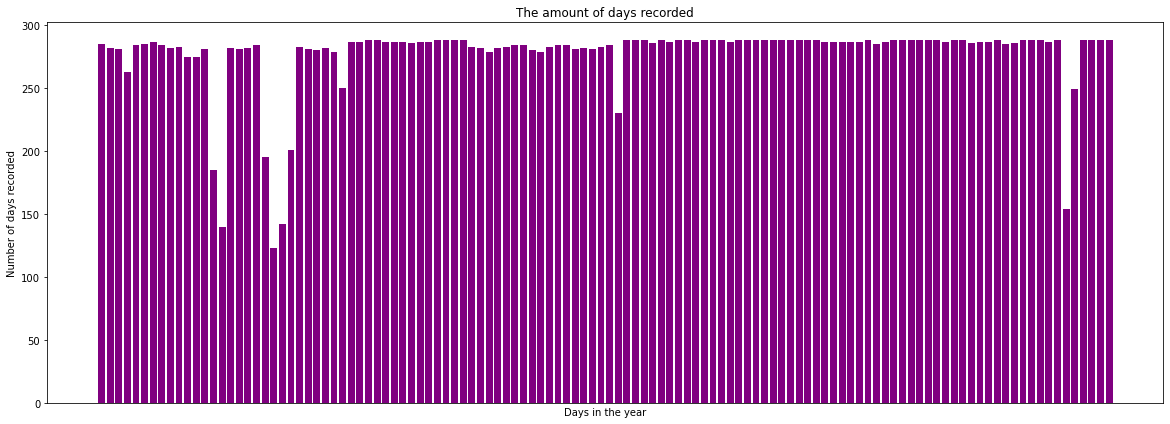

In [43]:
count = Counter(time)
plt.figure(figsize=(20, 7))
plt.bar(count.keys(), count.values(), color='purple')
plt.xticks([])
plt.xlabel('Days in the year')
plt.ylabel('Number of days recorded')
plt.title('The amount of days recorded')
plt.show()

# Feature transformation

The next step is to use transformations on our dataset.

This is a visualisation of the distribution of the different features compared to them being transformed with Log, BoxCox, Standard Scaler and MinMax Scaler.

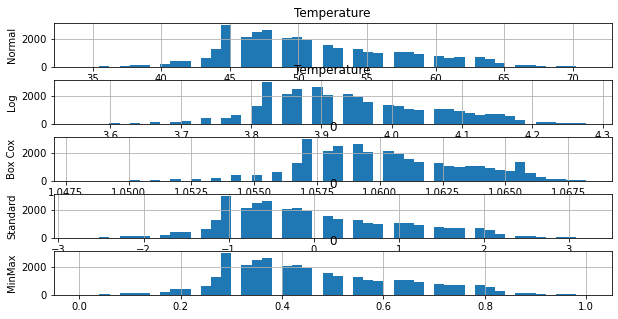

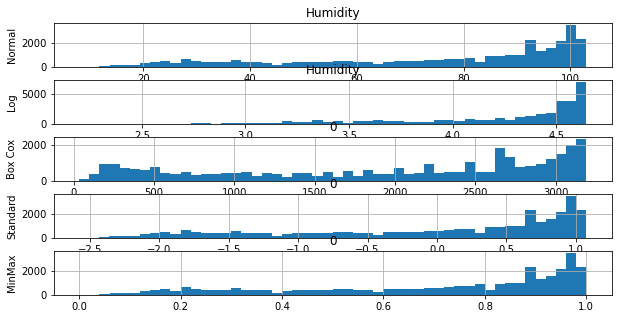

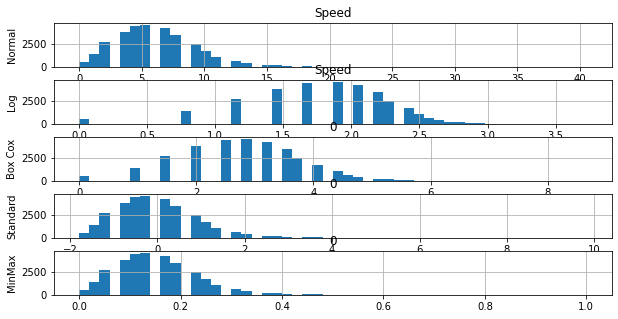

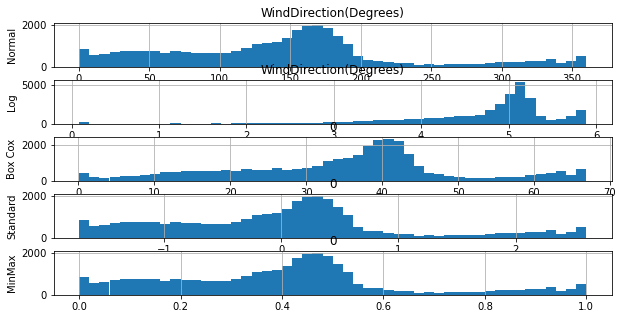

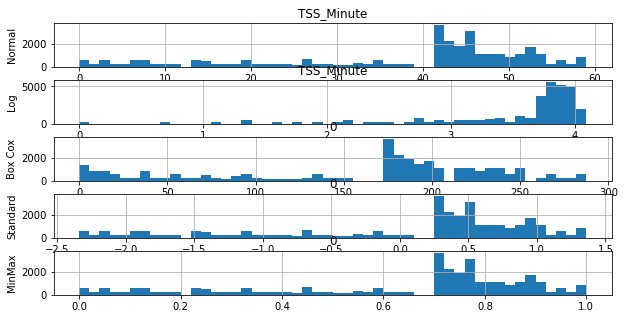

In [44]:
norm = {'Temperature' : (X['Temperature']+1).transform(np.log), 
        'Humidity' : stats.boxcox(X['Humidity']+1)[0], 'Speed' : (X['Speed']+1).transform(np.log), 
        'WindDirection(Degrees)' : MinMaxScaler().fit_transform(np.array(X['WindDirection(Degrees)']).reshape(-1, 1)),
        'TSS_Minute' : stats.boxcox(X['TSS_Minute']+1)[0]}

for i in norm:
    b=50
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    pd.DataFrame(X[i]).hist(ax=ax1, bins=b)
    pd.DataFrame((X[i]+1).transform(np.log)).hist(ax=ax2, bins=b)
    pd.DataFrame(stats.boxcox(X[i]+1)[0]).hist(ax=ax3, bins=b)
    
    pd.DataFrame(StandardScaler().fit_transform(np.array(X[i]).reshape(-1, 1))).hist(ax=ax4, bins=b)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(X[i]).reshape(-1, 1))).hist(ax=ax5, bins=b)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')
    
    X[i] = norm[i]

# Drop Unnecessries data

In [45]:
X = X.drop(['Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis=1)

In [46]:
X.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TSR_Minute,TSS_Minute,TSS_Hour,Month,Day,Hour,Minute,Second
0,3.89182,30.46,1139.358665,0.492692,1.890095,13,32.81851,1,9,29,23,55,26
1,3.89182,30.46,1104.046980,0.490996,1.474763,13,32.81851,1,9,29,23,50,23
2,3.89182,30.46,1069.253545,0.440894,1.474763,13,32.81851,1,9,29,23,45,26
3,3.89182,30.46,1175.187489,0.382426,1.474763,13,32.81851,1,9,29,23,40,21
4,3.89182,30.46,1248.392213,0.291391,1.890095,13,32.81851,1,9,29,23,35,24


# Binning

The last piece of feature engineering with the X and y variables is to bin the WindDirection, TimeSunSet Minute and Humidity features.

In [47]:
X['WindDirection(Degrees)_bin'] = np.digitize(X['WindDirection(Degrees)'], np.arange(0.0, 1.0, 0.02).tolist())
X['TSS_Minute_bin'] = np.digitize(X['TSS_Minute'], np.arange(0.0, 288.0, 12).tolist())
X['Humidity_bin'] = np.digitize(X['Humidity'], np.arange(32, 3192, 128).tolist())

# The following graphs are visualisations showing the distribution of the data we recorded.

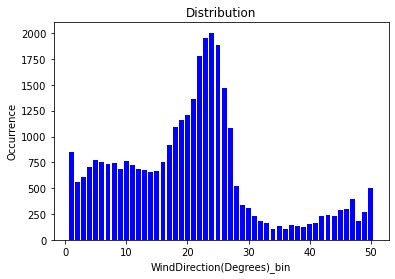

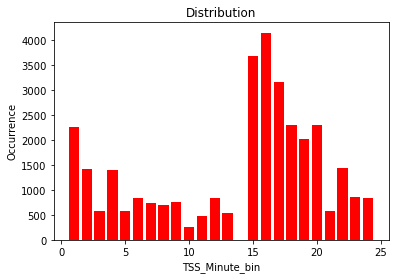

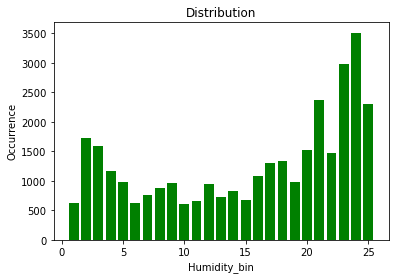

In [48]:
feats = {'WindDirection(Degrees)_bin':'blue', 'TSS_Minute_bin':'red', 'Humidity_bin':'green'}
for i in feats:
    count = Counter(X[i])
    plt.bar(count.keys(), count.values(), color=feats[i])
    plt.title('Distribution')
    plt.ylabel('Occurrence')
    plt.xlabel(i)
    plt.show()

In [49]:
X.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TSR_Minute,TSS_Minute,TSS_Hour,Month,Day,Hour,Minute,Second,WindDirection(Degrees)_bin,TSS_Minute_bin,Humidity_bin
0,3.89182,30.46,1139.358665,0.492692,1.890095,13,32.81851,1,9,29,23,55,26,25,3,9
1,3.89182,30.46,1104.046980,0.490996,1.474763,13,32.81851,1,9,29,23,50,23,25,3,9
2,3.89182,30.46,1069.253545,0.440894,1.474763,13,32.81851,1,9,29,23,45,26,23,3,9
3,3.89182,30.46,1175.187489,0.382426,1.474763,13,32.81851,1,9,29,23,40,21,20,3,9
4,3.89182,30.46,1248.392213,0.291391,1.890095,13,32.81851,1,9,29,23,35,24,15,3,10


# This is the correlation of all the variables in our dataset

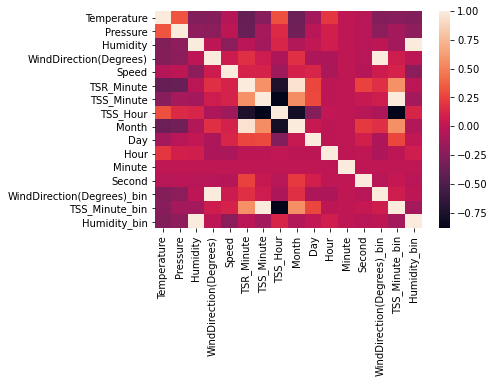

In [50]:
sns.heatmap(X.corr())
plt.show()

In [51]:
X.describe()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TSR_Minute,TSS_Minute,TSS_Hour,Month,Day,Hour,Minute,Second,WindDirection(Degrees)_bin,TSS_Minute_bin,Humidity_bin
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,3.946313,30.422879,1946.794322,0.398488,1.859223,27.640519,157.988841,0.347886,10.526066,15.825766,11.557425,27.556691,17.441902,20.421098,13.691489,15.450805
std,0.117019,0.054673,1007.881696,0.231111,0.520981,15.518714,80.819626,0.476307,1.096691,8.711824,6.912034,17.268507,12.951109,11.532145,6.720589,7.879532
min,3.555348,30.190000,32.143940,0.000000,0.000000,7.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3.850148,30.400000,1034.979494,0.228248,1.474763,14.000000,87.790602,0.000000,10.000000,9.000000,6.000000,15.000000,5.000000,12.000000,8.000000,8.000000
50%,3.931826,30.430000,2236.092852,0.410187,1.890095,24.000000,181.468050,0.000000,11.000000,16.000000,12.000000,30.000000,18.000000,21.000000,16.000000,18.000000
75%,4.025352,30.460000,2855.773244,0.498027,2.182675,40.000000,212.893273,1.000000,11.000000,23.000000,18.000000,45.000000,22.000000,25.000000,18.000000,23.000000
max,4.276666,30.560000,3191.915065,1.000000,3.725693,57.000000,287.465729,1.000000,12.000000,31.000000,23.000000,57.000000,59.000000,50.000000,24.000000,25.000000


In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Temperature                 32686 non-null  float64
 1   Pressure                    32686 non-null  float64
 2   Humidity                    32686 non-null  float64
 3   WindDirection(Degrees)      32686 non-null  float64
 4   Speed                       32686 non-null  float64
 5   TSR_Minute                  32686 non-null  int64  
 6   TSS_Minute                  32686 non-null  float64
 7   TSS_Hour                    32686 non-null  int64  
 8   Month                       32686 non-null  int64  
 9   Day                         32686 non-null  int64  
 10  Hour                        32686 non-null  int64  
 11  Minute                      32686 non-null  int64  
 12  Second                      32686 non-null  int64  
 13  WindDirection(Degrees)_bin  326

# Data Spilt for model performance Analysis

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
1. Finally, we have created a neural network which predicts the level of solar radiation.

# Artificial Neural Networks(ANNs) or Deep Learning Neural Network(DNNs)

In [55]:
model = Sequential()
    
model.add(Dense(256, activation='relu', input_dim=16))
model.add(Dropout(0.25))
    
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='linear'))

# Model Compile

In [56]:
model.compile(metrics='mse',
              loss='mae',
              optimizer=Adam(learning_rate=0.003))


# Model fit

In [57]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=70,
                    batch_size=64)

Epoch 1/70
460/460 [==============================] - 1s 2ms/step - loss: 110.4607 - mse: 46707.4844 - val_loss: 72.6803 - val_mse: 21227.9531
Epoch 2/70
460/460 [==============================] - 1s 2ms/step - loss: 83.6195 - mse: 26942.3008 - val_loss: 65.9651 - val_mse: 17570.7070
Epoch 3/70
460/460 [==============================] - 1s 2ms/step - loss: 79.5642 - mse: 25024.1738 - val_loss: 59.4619 - val_mse: 14928.4805
Epoch 4/70
460/460 [==============================] - 1s 2ms/step - loss: 76.8647 - mse: 23653.5156 - val_loss: 57.6805 - val_mse: 14564.0479
Epoch 5/70
460/460 [==============================] - 1s 2ms/step - loss: 74.7188 - mse: 22393.2344 - val_loss: 52.8932 - val_mse: 12504.5820
Epoch 6/70
460/460 [==============================] - 1s 2ms/step - loss: 73.5362 - mse: 22097.6016 - val_loss: 54.8126 - val_mse: 13174.0322
Epoch 7/70
460/460 [==============================] - 1s 2ms/step - loss: 72.8532 - mse: 21616.3125 - val_loss: 58.9909 - val_mse: 14511.6211
Epoch

460/460 [==============================] - 1s 2ms/step - loss: 61.5623 - mse: 16755.8906 - val_loss: 43.9046 - val_mse: 10239.7891
Epoch 59/70
460/460 [==============================] - 1s 2ms/step - loss: 61.1011 - mse: 16366.3867 - val_loss: 43.4739 - val_mse: 10060.2148
Epoch 60/70
460/460 [==============================] - 1s 2ms/step - loss: 61.0553 - mse: 16350.0938 - val_loss: 42.8580 - val_mse: 9880.2168
Epoch 61/70
460/460 [==============================] - 1s 2ms/step - loss: 60.9612 - mse: 16359.1533 - val_loss: 43.0537 - val_mse: 10090.8096
Epoch 62/70
460/460 [==============================] - 1s 2ms/step - loss: 61.5790 - mse: 16818.4238 - val_loss: 46.0526 - val_mse: 10478.9307
Epoch 63/70
460/460 [==============================] - 1s 2ms/step - loss: 61.0784 - mse: 16447.5293 - val_loss: 42.9155 - val_mse: 10032.9697
Epoch 64/70
460/460 [==============================] - 1s 2ms/step - loss: 61.2016 - mse: 16555.9414 - val_loss: 43.6560 - val_mse: 9748.1650
Epoch 65/70
4

 Below are the scores we have achieved for mean absolute error and mean squared error.

# Results

In [58]:
fit = history.history
scores = model.evaluate(X_test, y_test)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ' + str(mae) + '. Mean squared error: ' + str(mse) + '.')



103/103 [==============================] - 0s 1ms/step - loss: 46.9189 - mse: 10907.1484
Mean absolute error: 46.918907165527344. Mean squared error: 10907.1484375.


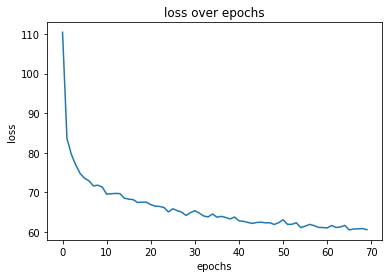

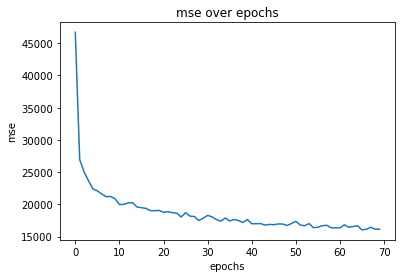

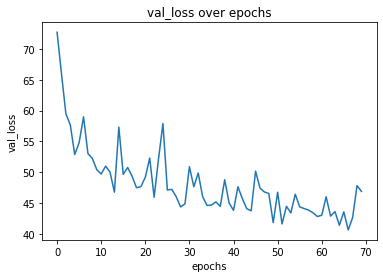

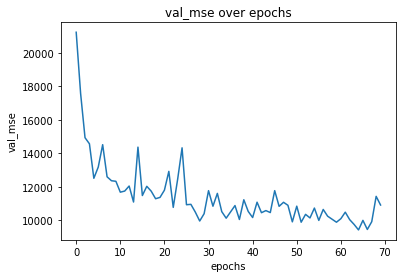

In [59]:
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()